In [1]:
!pip install dgl

     |████████████████████████████████| 3.0MB 8.4MB/s 


In [2]:
#Import the libraries
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


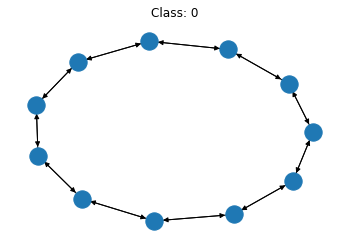

In [3]:
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

In [4]:
#Collate function to form mini batch
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [5]:
#Readout and classification
from dgl.nn.pytorch import GraphConv
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [6]:
#Training and Evaluation
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
model = Classifier(1, 256, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0160
Epoch 1, loss 1.9768
Epoch 2, loss 1.9611
Epoch 3, loss 1.9487
Epoch 4, loss 1.9437
Epoch 5, loss 1.9305
Epoch 6, loss 1.9202
Epoch 7, loss 1.9009
Epoch 8, loss 1.8845
Epoch 9, loss 1.8520
Epoch 10, loss 1.8185
Epoch 11, loss 1.7794
Epoch 12, loss 1.7334
Epoch 13, loss 1.6826
Epoch 14, loss 1.6221
Epoch 15, loss 1.5580
Epoch 16, loss 1.4928
Epoch 17, loss 1.4309
Epoch 18, loss 1.3689
Epoch 19, loss 1.3040
Epoch 20, loss 1.2526
Epoch 21, loss 1.2020
Epoch 22, loss 1.1559
Epoch 23, loss 1.1173
Epoch 24, loss 1.0861
Epoch 25, loss 1.0537
Epoch 26, loss 1.0442
Epoch 27, loss 1.0067
Epoch 28, loss 0.9867
Epoch 29, loss 0.9671
Epoch 30, loss 0.9353
Epoch 31, loss 0.9085
Epoch 32, loss 0.8956
Epoch 33, loss 0.8864
Epoch 34, loss 0.8780
Epoch 35, loss 0.8674
Epoch 36, loss 0.8376
Epoch 37, loss 0.8251
Epoch 38, loss 0.8077
Epoch 39, loss 0.8253
Epoch 40, loss 0.8026
Epoch 41, loss 0.7883
Epoch 42, loss 0.7944
Epoch 43, loss 0.7720
Epoch 44, loss 0.7735
Epoch 45, loss 0.761

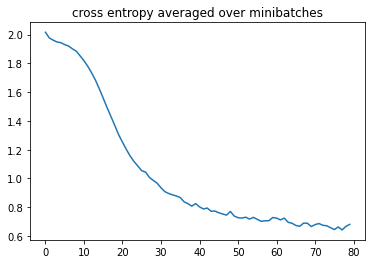

In [7]:
#Cross Entropy over minibatches
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [12]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 63.7500%
Accuracy of argmax predictions on the test set: 70.000000%
